# aai-510-group2-final-project

# Cluster Quest - Mapping Social Cohorts in Facebook Networks

## Team Members:

Alejandro Marchini

Carlos Alberto Ortiz Montes De Oca

Swathi Subramanyam Pabbathi

pip install -r requirements.txt

In [88]:
# import all necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from math import log
import networkx as nx
from igraph import Graph, plot
import igraph as ig
from math import log
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import community as community_louvain

import scipy.sparse
from scipy.stats import zscore
from scipy.stats import skew


Networkx EDA

In [89]:
# Load edges from text file
edge_file = 'facebook_combined.txt'

#https://medium.com/@tushar_aggarwal/networkx-a-comprehensive-guide-to-mastering-network-analysis-with-python-fd7e5195f6a0
# Each line contains two node IDs separated by space
G = nx.read_edgelist(edge_file, nodetype=int)

print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph loaded with 4039 nodes and 88234 edges.


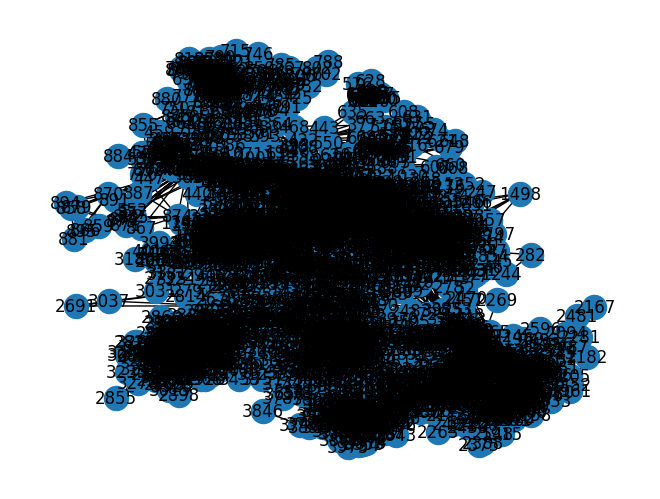

In [90]:
# Leviathan plot
nx.draw(G, with_labels  =True)
plt.show()

Detected 13 communities


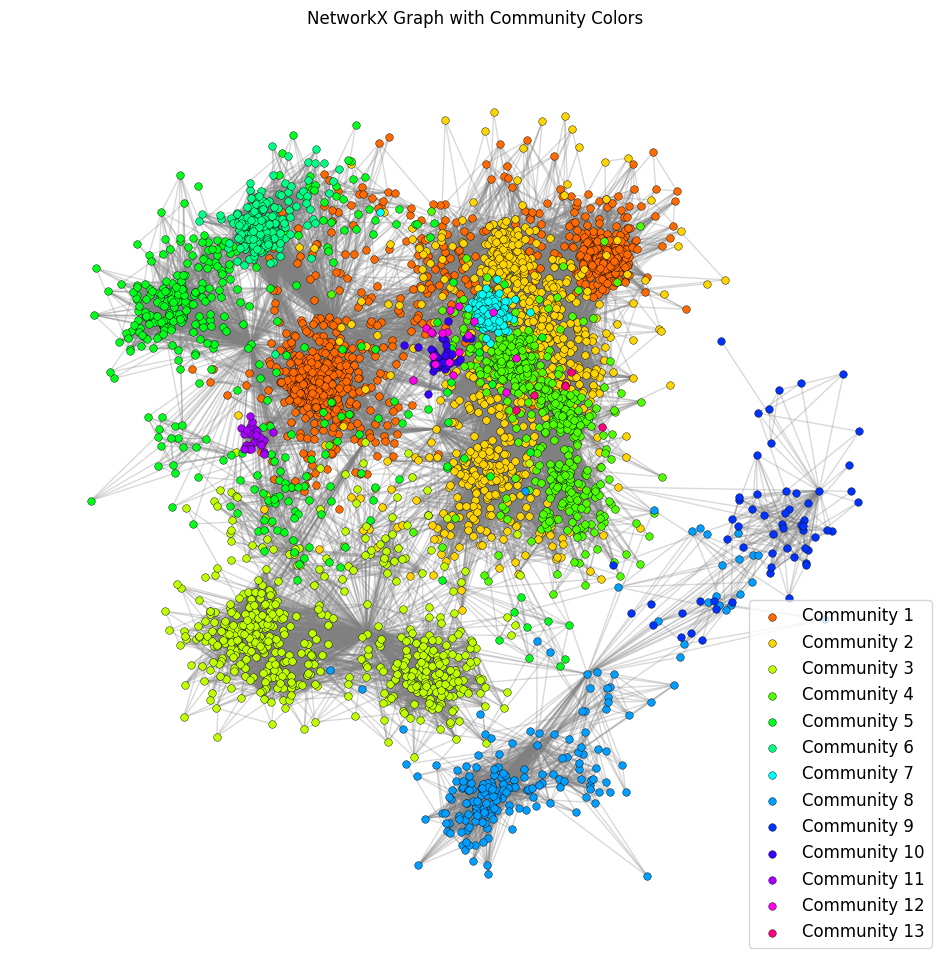

In [91]:
# Example community detection: use greedy modularity communities from NetworkX
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
print(f"Detected {len(communities)} communities")

# Compute layout once
pos = nx.spring_layout(G, seed=42)

# Prepare color palette
palette = sns.color_palette("hsv", len(communities))

plt.figure(figsize=(12, 12))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')

# Draw nodes community by community
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(community),
        node_color=[palette[i]],
        node_size=30,
        label=f'Community {i+1}',
        edgecolors='k',
        linewidths=0.3
    )

plt.title("NetworkX Graph with Community Colors")
plt.axis('off')
plt.legend(scatterpoints=1, fontsize=12)
plt.show()


In [92]:
#https://ocw.mit.edu/courses/14-15-networks-spring-2022/mit14_15s22_lec2.pdf
# Basic graph statistics

from collections import Counter

# Assume G is your undirected NetworkX graph

n = G.number_of_nodes()
m = G.number_of_edges()

# Average degree
avg_degree = 2 * m / n
print(f"Average degree: {avg_degree:.4f}")

# Density
density = nx.density(G)
print(f"Density: {density:.4f}")

# Degree distribution
#degrees = [d for n, d in G.degree()]
#degree_count = Counter(degrees)
#degree_distribution = {deg: count / n for deg, count in degree_count.items()}
#print("Degree distribution (degree: fraction):")
#for deg, frac in sorted(degree_distribution.items()):
#    print(f"{deg}: {frac:.4f}")

# Diameter
try:
    diameter = nx.diameter(G)
    print(f"Diameter: {diameter}")
except nx.NetworkXError:
    print("Graph not connected; diameter undefined.")

# Average path length
try:
    avg_path_length = nx.average_shortest_path_length(G)
    print(f"Average path length: {avg_path_length:.4f}")
except nx.NetworkXError:
    print("Graph not connected; average path length undefined.")

# Average clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient (LCC): {avg_clustering:.4f}")

# Number of triangles
triangles = sum(nx.triangles(G).values()) // 3
print(f"Number of triangles (LCC): {triangles}")


Average degree: 43.6910
Density: 0.0108
Diameter: 8
Average path length: 3.6925
Average clustering coefficient (LCC): 0.6055
Number of triangles (LCC): 1612010


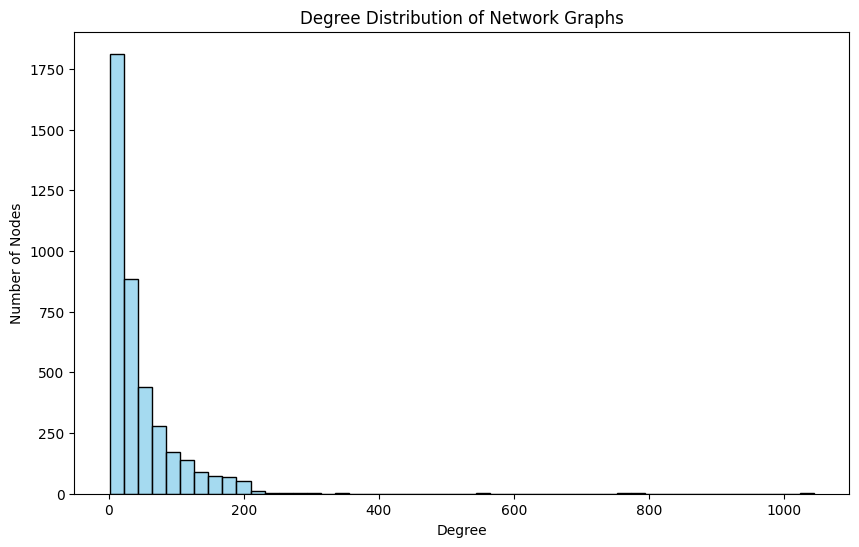

In [93]:
degrees = [d for n, d in G.degree()]
plt.figure(figsize=(10, 6))
sns.histplot(degrees, bins=50, kde=False, color='skyblue')
plt.title('Degree Distribution of Network Graphs')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

In [94]:
def two_hop_neighbors(G, node):
    neighbors = set(G.neighbors(node))
    two_hop = set()
    for n in neighbors:
        two_hop.update(G.neighbors(n))
    two_hop -= neighbors
    two_hop.discard(node)
    return len(two_hop)

def participation_coefficient(G, partition, node):
    neighbors = set(G.neighbors(node))
    if not neighbors:
        return 0
    community_counts = {}
    for n in neighbors:
        comm = partition[n]
        community_counts[comm] = community_counts.get(comm, 0) + 1
    total = sum(community_counts.values())
    return 1 - sum((count / total) ** 2 for count in community_counts.values())

In [95]:
#Network Analysis General Features
features = pd.DataFrame(index=G.nodes())
features = features.reset_index().rename(columns={'index': 'node'})
features['degree'] = pd.Series(dict(G.degree()))
features['clustering'] = pd.Series(nx.clustering(G))
features['betweenness'] = pd.Series(nx.betweenness_centrality(G))
features['closeness'] = pd.Series(nx.closeness_centrality(G))
features['eigenvector'] = pd.Series(nx.eigenvector_centrality(G))
features['triangles'] = pd.Series(nx.triangles(G))
features['avg_neigh_degree'] = pd.Series(nx.average_neighbor_degree(G))
features['page_rank'] = pd.Series(nx.pagerank(G))
features['k_core_number'] = pd.Series(nx.core_number(G))

#Centrality Variation features
features['katz_c'] = pd.Series(nx.katz_centrality_numpy(G))
features['harmonic_c'] = pd.Series(nx.harmonic_centrality(G))
features['load_c'] = pd.Series(nx.load_centrality(G))

#2-Hop and Local Neighborhood Features
features['avg_neighbor_clustering'] = features['node'].apply(
    lambda x: np.mean([nx.clustering(G, n) for n in G.neighbors(x)]) if len(list(G.neighbors(x))) > 0 else 0
)

features['egonet_edge_count'] = features['node'].apply(
    lambda x: nx.ego_graph(G, x).number_of_edges()
)

features['two_hop_neighbors'] = features['node'].apply(lambda x: two_hop_neighbors(G, x))

#Community/Misc
features['constraint'] = pd.Series(nx.constraint(G))

partition = community_louvain.best_partition(G)
features['participation_coeff'] = features['node'].apply(lambda x: participation_coefficient(G, partition, x))


In [96]:
features.shape

(4039, 18)

In [97]:
features.head(10)

,node,degree,clustering,betweenness,closeness,eigenvector,triangles,avg_neigh_degree,page_rank,k_core_number,katz_c,harmonic_c,load_c,avg_neighbor_clustering,egonet_edge_count,two_hop_neighbors,constraint,participation_coeff
0,0,347,0.041962,1.463059e-01,0.353343,3.391796e-05,2519,18.959654,0.006290,21,0.043520,1689.983333,1.458927e-01,0.647737,2866,1171,0.010754,0.028519
1,1,17,0.419118,2.783274e-06,0.261376,6.045346e-07,57,48.235294,0.000236,13,0.003200,1151.419048,2.783274e-06,0.478404,74,330,0.098366,0.000000
2,2,10,0.888889,7.595021e-08,0.261258,2.233461e-07,40,49.900000,0.000203,9,-0.002886,1147.919048,7.595021e-08,0.603024,50,337,0.210843,0.000000
3,3,17,0.632353,1.685066e-06,0.261376,6.635648e-07,86,59.764706,0.000226,13,-0.005344,1151.419048,1.685066e-06,0.479034,103,330,0.100185,0.000000
4,4,10,0.866667,1.840332e-07,0.261258,2.236416e-07,39,42.600000,0.000238,9,0.006269,1147.919048,1.840332e-07,0.847529,49,337,0.320289,0.000000
5,5,13,0.333333,2.205964e-06,0.261308,1.183322e-06,26,50.615385,0.000202,10,0.002780,1149.419048,2.205964e-06,0.539993,39,334,0.116046,0.000000
6,6,6,0.933333,2.453776e-08,0.261190,2.170904e-07,14,63.500000,0.000180,5,0.002209,1145.919048,2.453776e-08,0.655406,20,341,0.414134,0.000000
7,7,20,0.431579,1.702985e-04,0.274769,2.568510e-05,82,45.900000,0.000263,12,0.016808,1224.669048,1.665457e-04,0.473435,102,438,0.103530,0.095000
8,8,8,0.678571,2.760498e-07,0.261224,2.197375e-07,19,48.375000,0.000237,5,0.002600,1146.919048,2.760498e-07,0.724888,27,339,0.370425,0.000000
9,9,57,0.397243,1.645424e-05,0.262055,2.214117e-06,634,42.403509,0.000600,21,-0.002860,1171.419048,1.645424e-05,0.502546,691,290,0.048298,0.000000


### Data Preparation

In [98]:
#Missing values
missing_counts = features.isnull().sum()
missing_ratio = missing_counts / len(features)
print(missing_ratio[missing_ratio > 0])

Series([], dtype: float64)


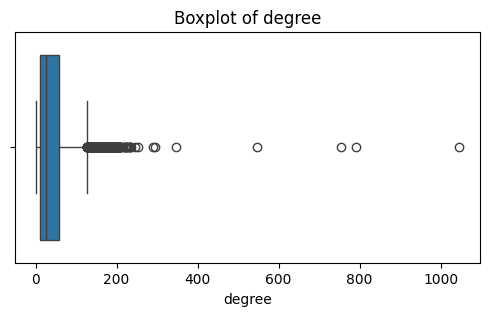

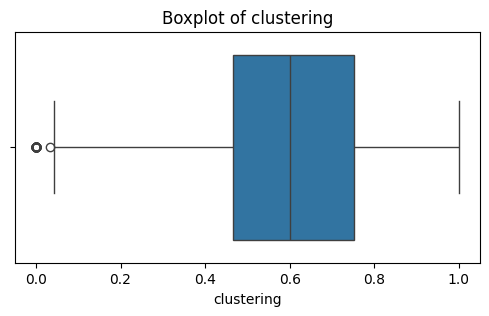

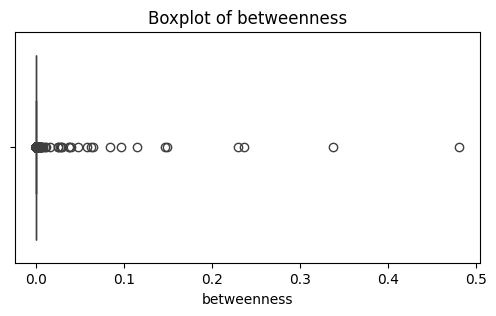

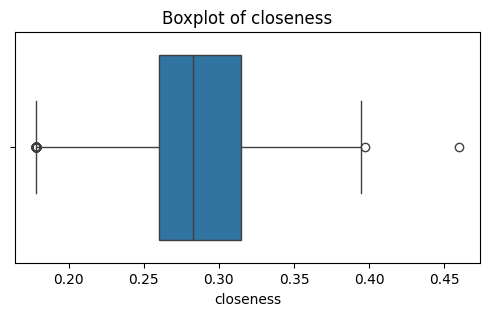

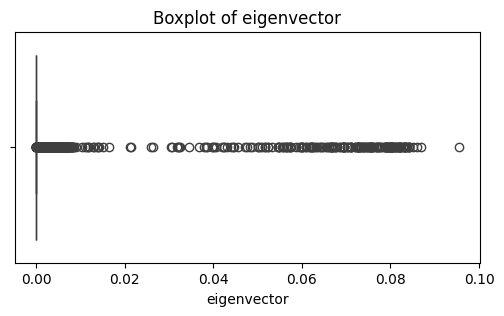

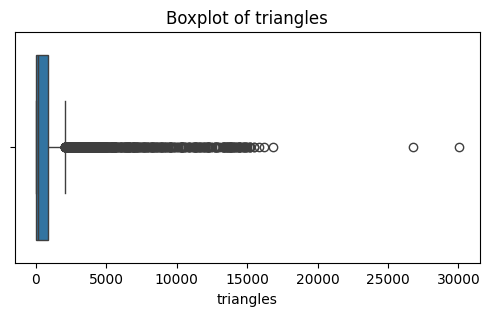

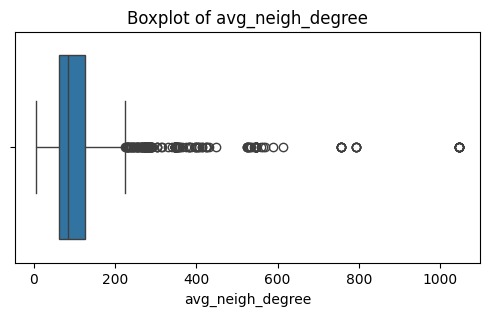

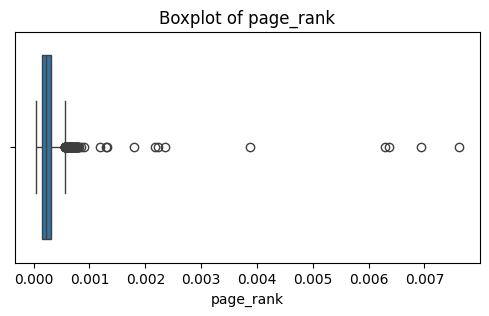

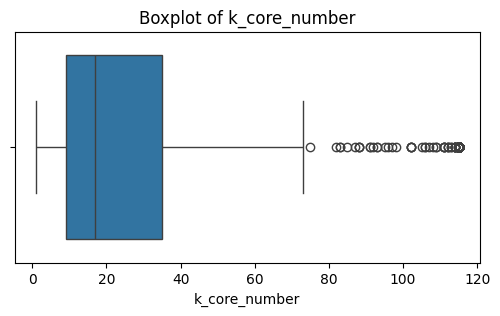

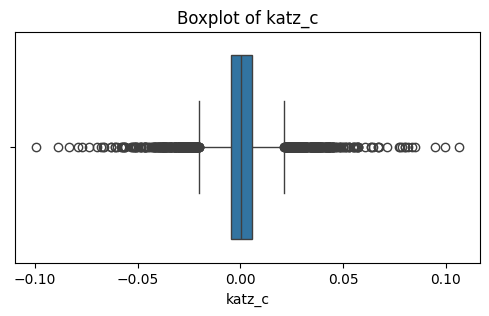

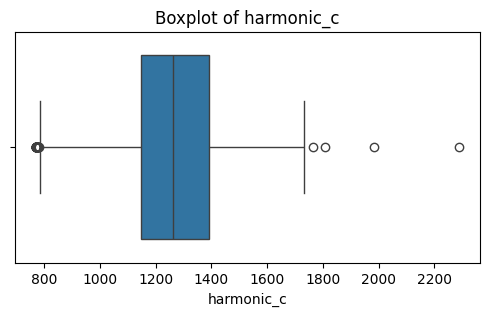

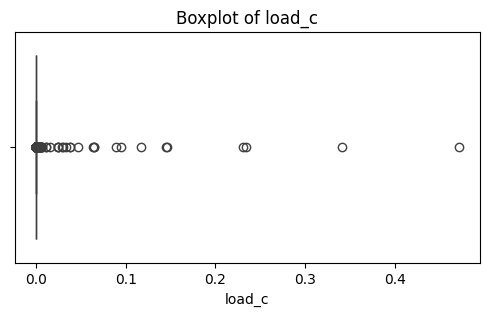

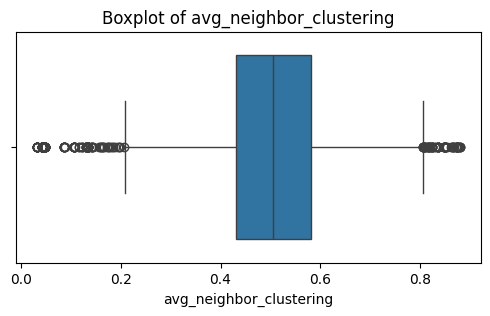

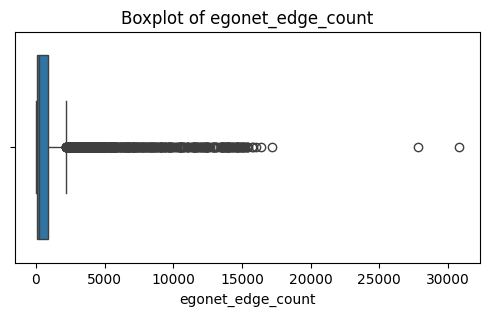

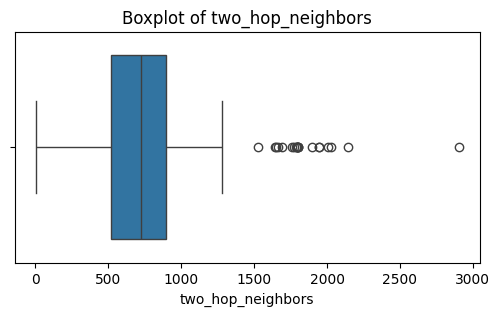

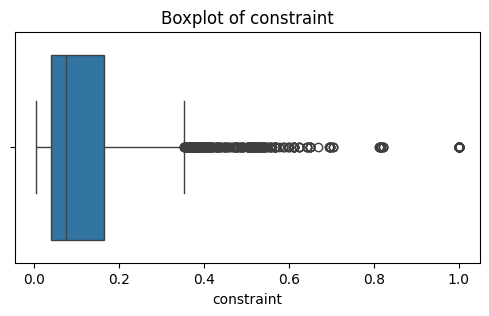

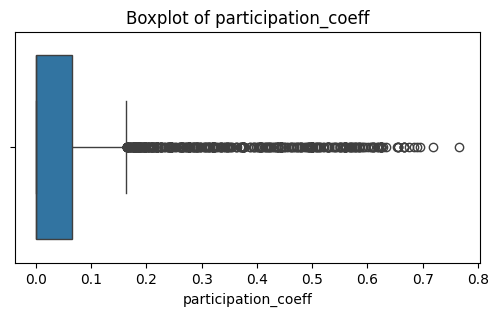

In [99]:
for col in features.columns[1:]:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=features[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

Most variables contain A LOT of Outliers.

In [100]:
features_zscore = features.copy()
features_zscore = features_zscore.drop("node", axis=1)
features_zscore = features_zscore.apply(zscore)
outliers = (features_zscore.abs() > 3)
outlier_counts = outliers.sum()
outlier_ratio = outlier_counts / len(features)
print("Number of outliers per feature:\n", outlier_counts)

Number of outliers per feature:
 degree                      40
clustering                   0
betweenness                 16
closeness                    5
eigenvector                182
triangles                  144
avg_neigh_degree            69
page_rank                   12
k_core_number              177
katz_c                      80
harmonic_c                   4
load_c                      15
avg_neighbor_clustering     43
egonet_edge_count          143
two_hop_neighbors           20
constraint                 102
participation_coeff        153
dtype: int64


In [101]:
low_ratio = {}
moderate_ratio = {}

for feature, ratio in outlier_ratio.items():
    if ratio <= 0.02:
        low_ratio[feature] = ratio
    else:
        moderate_ratio[feature] = ratio

print("Features with low outlier ratio (<= 2%):")
for f, r in low_ratio.items():
    print(f"{f}: {r:.4f}")

print("\nFeatures with moderate/high outlier ratio (> 2%):")
for f, r in moderate_ratio.items():
    print(f"{f}: {r:.4f}")

Features with low outlier ratio (<= 2%):
degree: 0.0099
clustering: 0.0000
betweenness: 0.0040
closeness: 0.0012
avg_neigh_degree: 0.0171
page_rank: 0.0030
katz_c: 0.0198
harmonic_c: 0.0010
load_c: 0.0037
avg_neighbor_clustering: 0.0106
two_hop_neighbors: 0.0050

Features with moderate/high outlier ratio (> 2%):
eigenvector: 0.0451
triangles: 0.0357
k_core_number: 0.0438
egonet_edge_count: 0.0354
constraint: 0.0253
participation_coeff: 0.0379


In [102]:
def windsorize_series(s, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = s.quantile(lower_quantile)
    upper_bound = s.quantile(upper_quantile)
    return s.clip(lower=lower_bound, upper=upper_bound)

features_to_windsorize = ['eigenvector', 'triangles', 'k_core_number', 'participation_coeff', 'constraint', 'egonet_edge_count']

for col in features_to_windsorize:
    features[col] = windsorize_series(features[col])

features_to_trim = ['degree', 'betweenness', 'closeness', 'harmonic_c', 'load_c', 'page_rank','clustering','avg_neigh_degree','katz_c','avg_neighbor_clustering','avg_neighbor_clustering']
mask = np.ones(len(features), dtype=bool)

for col in features_to_trim:
    z_scores = zscore(features[col])
    mask &= (z_scores >= -3) & (z_scores <= 3)

features_filtered = features[mask].reset_index(drop=True)
features = features_filtered

In [103]:
features.head(10)

,node,degree,clustering,betweenness,closeness,eigenvector,triangles,avg_neigh_degree,page_rank,k_core_number,katz_c,harmonic_c,load_c,avg_neighbor_clustering,egonet_edge_count,two_hop_neighbors,constraint,participation_coeff
0,1,17,0.419118,2.783274e-06,0.261376,6.045346e-07,57.0,48.235294,0.000236,13.0,0.003200,1151.419048,2.783274e-06,0.478404,74.0,330,0.098366,0.000
1,2,10,0.888889,7.595021e-08,0.261258,2.233461e-07,40.0,49.900000,0.000203,9.0,-0.002886,1147.919048,7.595021e-08,0.603024,50.0,337,0.210843,0.000
2,3,17,0.632353,1.685066e-06,0.261376,6.635648e-07,86.0,59.764706,0.000226,13.0,-0.005344,1151.419048,1.685066e-06,0.479034,103.0,330,0.100185,0.000
3,4,10,0.866667,1.840332e-07,0.261258,2.236416e-07,39.0,42.600000,0.000238,9.0,0.006269,1147.919048,1.840332e-07,0.847529,49.0,337,0.320289,0.000
4,5,13,0.333333,2.205964e-06,0.261308,1.183322e-06,26.0,50.615385,0.000202,10.0,0.002780,1149.419048,2.205964e-06,0.539993,39.0,334,0.116046,0.000
5,6,6,0.933333,2.453776e-08,0.261190,2.170904e-07,14.0,63.500000,0.000180,5.0,0.002209,1145.919048,2.453776e-08,0.655406,20.0,341,0.414134,0.000
6,7,20,0.431579,1.702985e-04,0.274769,2.568510e-05,82.0,45.900000,0.000263,12.0,0.016808,1224.669048,1.665457e-04,0.473435,102.0,438,0.103530,0.095
7,8,8,0.678571,2.760498e-07,0.261224,2.197375e-07,19.0,48.375000,0.000237,5.0,0.002600,1146.919048,2.760498e-07,0.724888,27.0,339,0.370425,0.000
8,9,57,0.397243,1.645424e-05,0.262055,2.214117e-06,634.0,42.403509,0.000600,21.0,-0.002860,1171.419048,1.645424e-05,0.502546,691.0,290,0.048298,0.000
9,10,10,0.822222,4.986740e-08,0.261258,7.708567e-07,37.0,79.100000,0.000135,10.0,0.000335,1147.919048,4.986740e-08,0.387339,47.0,337,0.129758,0.000


In [ ]:
#Standard Scaling, because we are later applying PCA for dimensional reduction (before the Clustering Algorithms)
columns_to_scale = ['degree','betweenness','eigenvector','triangles','avg_neigh_degree','k_core_number','katz_c','harmonic_c','load_c','egonet_edge_count','two_hop_neighbors']

# Initialize the StandardScaler
scaler = StandardScaler()

# Extract the columns to be scaled
data_to_scale = features[columns_to_scale]

# Fit and transform the data
scaled_data = scaler.fit_transform(data_to_scale)

# Replace the original values with the scaled values
features[columns_to_scale] = scaled_data

## Data Transformation, Data Centering, and Visualization

In [105]:
# Exclude non-numeric columns like 'node'
numeric_cols = features.select_dtypes(include=[np.number]).columns

# Calculate skewness for each numeric feature
skewness = features[numeric_cols].apply(skew)

# Select features with absolute skewness > 1 (highly skewed)
skewed_features = skewness[skewness.abs() > 1].index.tolist()

print("Features to transform due to skewness:", skewed_features)

# Apply square root transform to skewed features
for col in skewed_features:
    min_val = features[col].min()
    if min_val < 0:
        # Shift to non-negative before sqrt if needed
        features[col] = np.sqrt(features[col] - min_val + 1)
    else:
        features[col] = np.sqrt(features[col])


Features to transform due to skewness: ['degree', 'betweenness', 'eigenvector', 'triangles', 'avg_neigh_degree', 'page_rank', 'k_core_number', 'load_c', 'egonet_edge_count', 'constraint', 'participation_coeff']


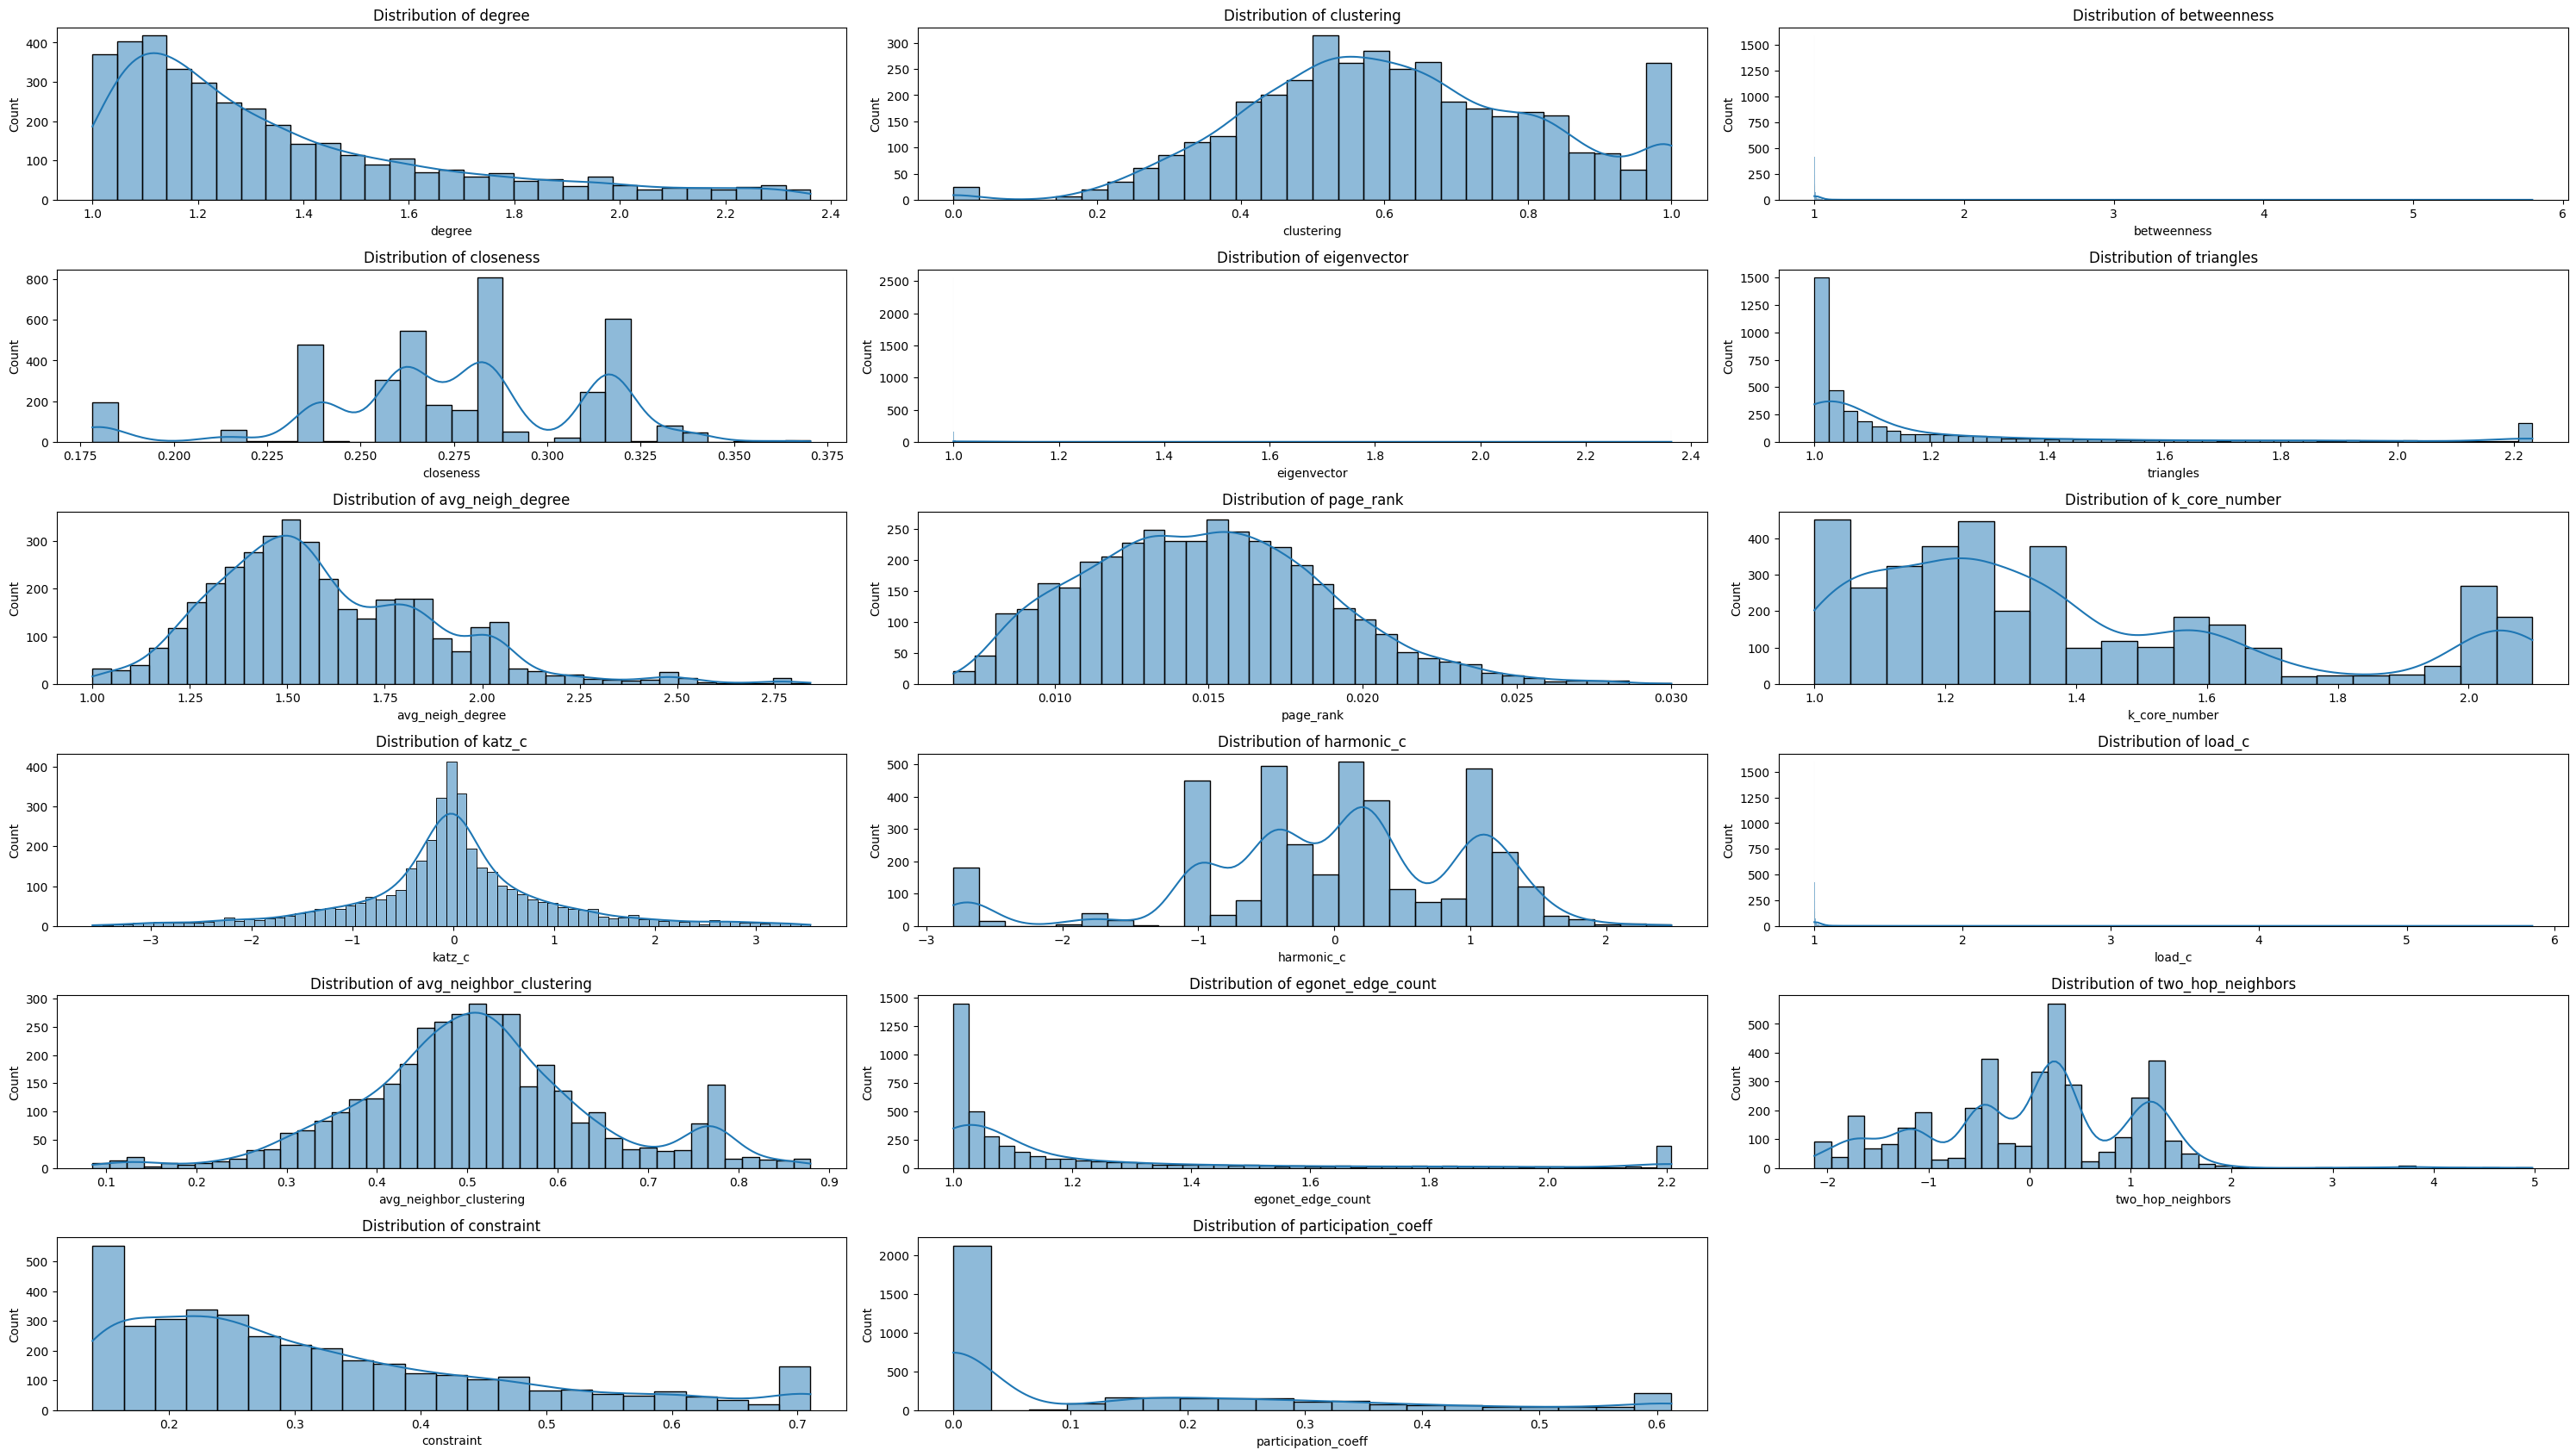

In [106]:
# Visualize the distribution of each feature
plt.figure(figsize=(30, 25))
for i, column in enumerate(features.columns[1:], 1):
    plt.subplot(9, 3, i)
    sns.histplot(features[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [110]:
features_to_trim = ['load_c', 'two_hop_neighbors','betweenness']
mask = np.ones(len(features), dtype=bool)

for col in features_to_trim:
    z_scores = zscore(features[col])
    mask &= (z_scores >= -3) & (z_scores <= 3)

features_filtered = features[mask].reset_index(drop=True)
features = features_filtered

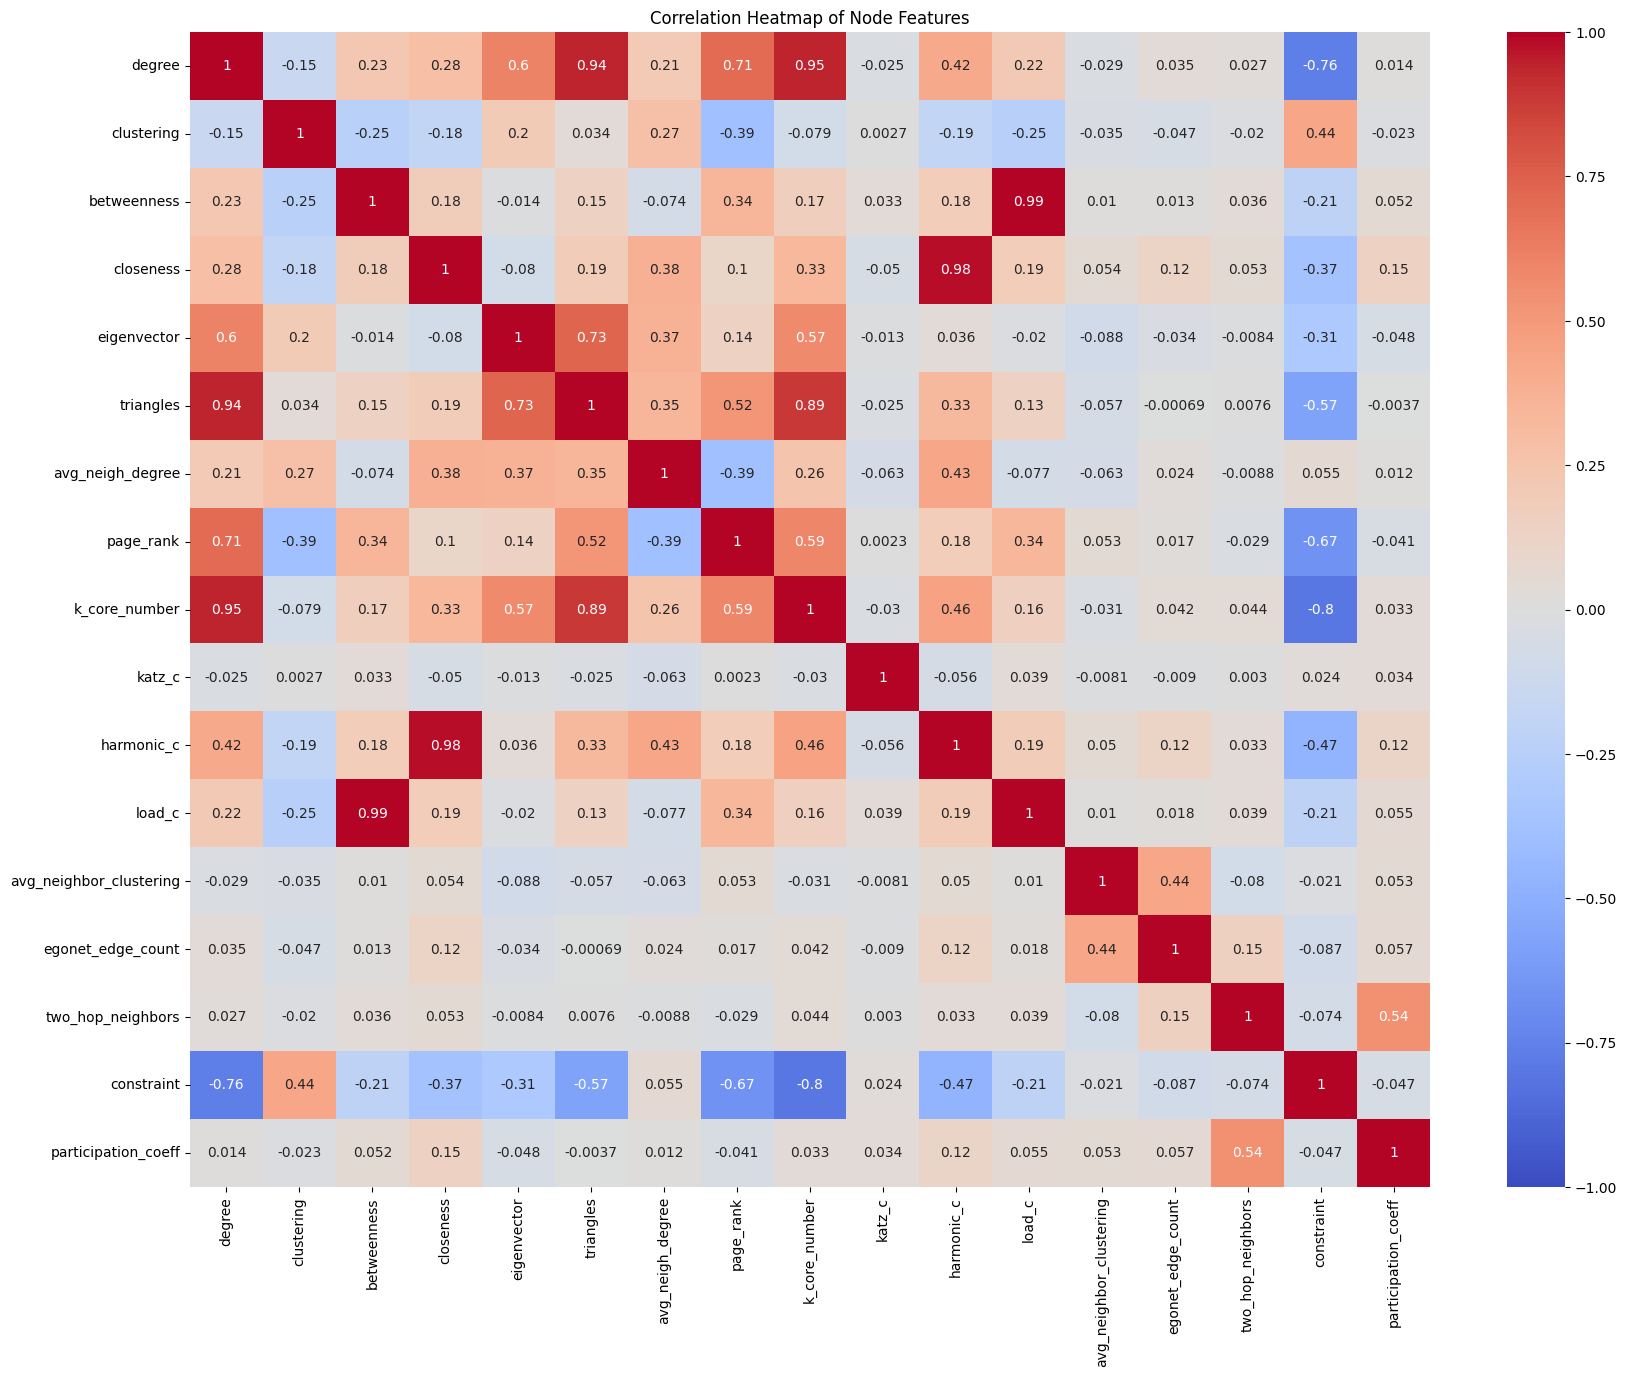

In [111]:
# Correlation heatmap to show relationships between features
plt.figure(figsize=(20, 15))
correlation_matrix = features.drop(columns=['node']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Node Features')
plt.show()

In [ ]:
columns_to_drop = ['katz_c','egonet_edge_count']
features = features.drop(columns_to_drop, axis=1)

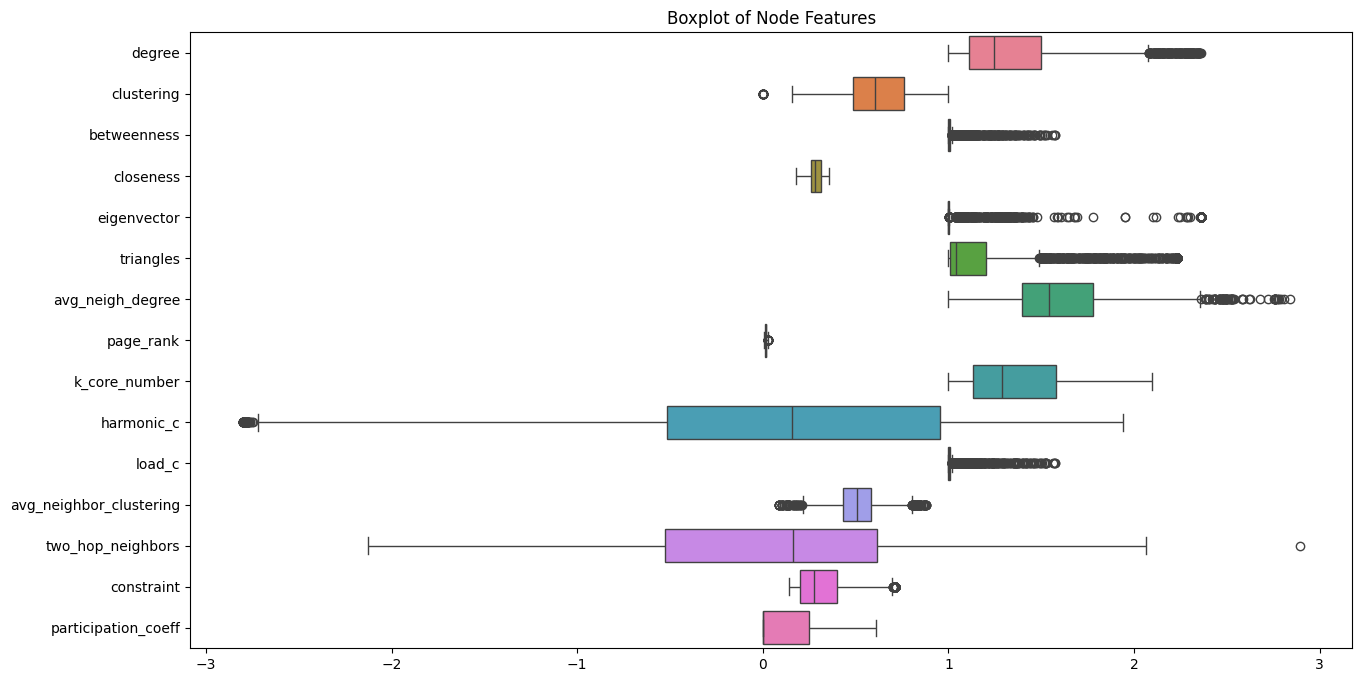

In [118]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Create a vertical box plot
sns.boxplot(data=features.drop(columns=['node']), orient='h')

# Add title and show the plot
plt.title('Boxplot of Node Features')
plt.show()

In [119]:
# export prepared data to a csv for use in other notebooks
features.to_csv('prepared_data_alt.csv', index=False)

## Model Building (Data Alt)

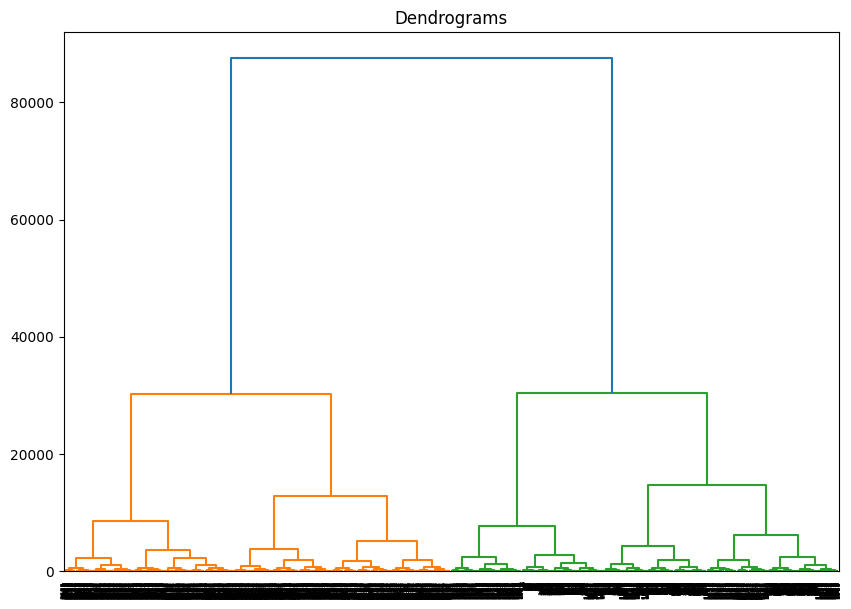

In [121]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(features, method='ward'))

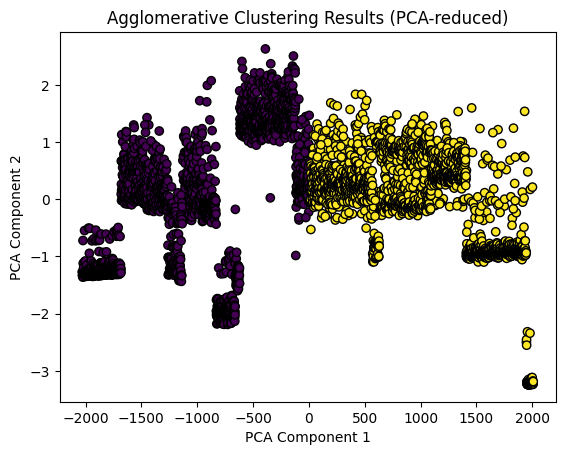

In [ ]:
#Two clusters given the vertical line dendogram rule
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

cluster = AgglomerativeClustering(n_clusters=2, linkage='ward', metric='euclidean')
labels = cluster.fit_predict(features)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title('Agglomerative Clustering Results (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [133]:
#Automating cluster search under a specified range
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']

best_score = -1
best_params = {}

for linkage in linkage_methods:
    # Ward linkage only supports euclidean metric
    metrics = ['euclidean']

    for metric in metrics:
        for n_clusters in range_n_clusters:
            try:
                clusterer = AgglomerativeClustering(
                    n_clusters=n_clusters,
                    linkage=linkage,
                    metric=metric
                )
                labels = clusterer.fit_predict(features)
                score = silhouette_score(features, labels, metric=metric)
                print(f"Linkage: {linkage}, Metric: {metric}, Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

                if score > best_score:
                    best_score = score
                    best_params = {
                        'linkage': linkage,
                        'metric': metric,
                        'n_clusters': n_clusters,
                        'score': score
                    }
            except Exception as e:
                # Some metric-linkage combos may not be valid; skip those
                print(f"Skipping linkage={linkage}, metric={metric}, n_clusters={n_clusters} due to error: {e}")

print("\nBest parameters found:")
print(best_params)


Linkage: ward, Metric: euclidean, Clusters: 2, Silhouette Score: 0.6279
Linkage: ward, Metric: euclidean, Clusters: 3, Silhouette Score: 0.5478
Linkage: ward, Metric: euclidean, Clusters: 4, Silhouette Score: 0.5525
Linkage: ward, Metric: euclidean, Clusters: 5, Silhouette Score: 0.5336
Linkage: ward, Metric: euclidean, Clusters: 6, Silhouette Score: 0.5342
Linkage: ward, Metric: euclidean, Clusters: 7, Silhouette Score: 0.5267
Linkage: ward, Metric: euclidean, Clusters: 8, Silhouette Score: 0.5214
Linkage: ward, Metric: euclidean, Clusters: 9, Silhouette Score: 0.5175
Linkage: ward, Metric: euclidean, Clusters: 10, Silhouette Score: 0.5070
Linkage: complete, Metric: euclidean, Clusters: 2, Silhouette Score: 0.5754
Linkage: complete, Metric: euclidean, Clusters: 3, Silhouette Score: 0.5832
Linkage: complete, Metric: euclidean, Clusters: 4, Silhouette Score: 0.5125
Linkage: complete, Metric: euclidean, Clusters: 5, Silhouette Score: 0.5242
Linkage: complete, Metric: euclidean, Clusters:

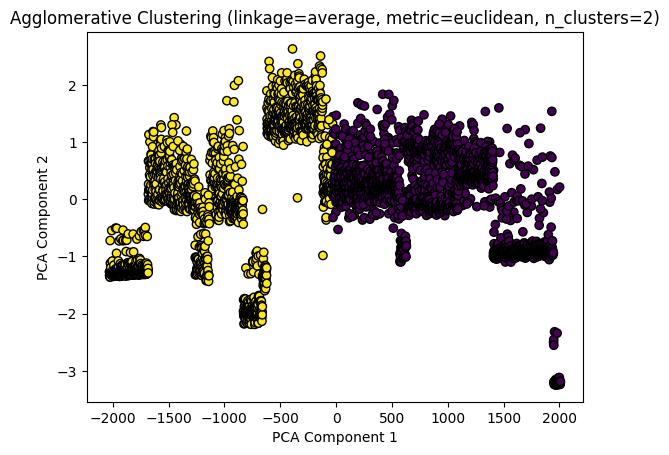

In [134]:
# Refit the best model
best_cluster = AgglomerativeClustering(
    n_clusters=best_params['n_clusters'],
    linkage=best_params['linkage'],
    metric=best_params['metric']
)
labels = best_cluster.fit_predict(features)

# Reduce data to 2D with PCA for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Plot clusters with colors
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title(f"Agglomerative Clustering (linkage={best_params['linkage']}, "
          f"metric={best_params['metric']}, n_clusters={best_params['n_clusters']})")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Same model as the one we discovered with our visual dendogram analysis.

## Model Building (Prepared Data)

In [140]:
# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('prepared_data.csv')
df = df.dropna()  # drops any row with NaN

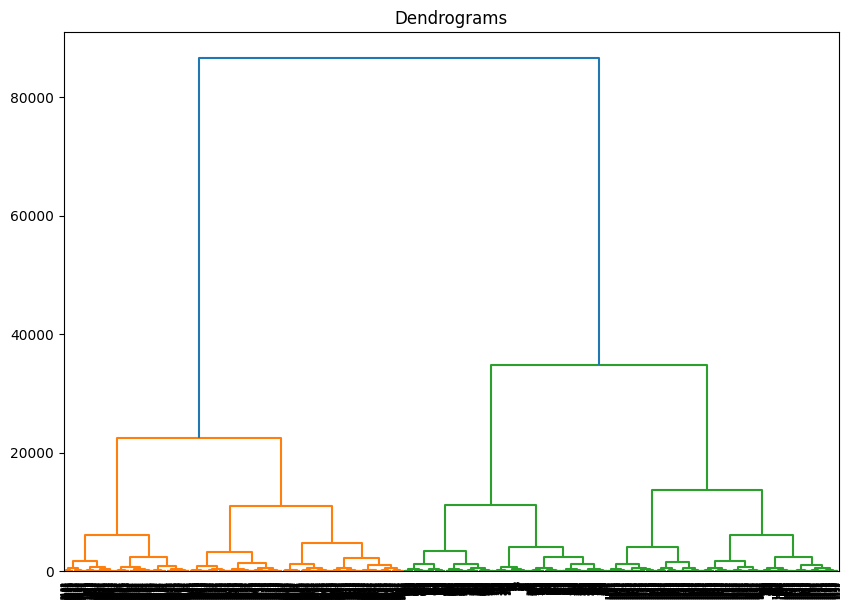

In [141]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df, method='ward'))

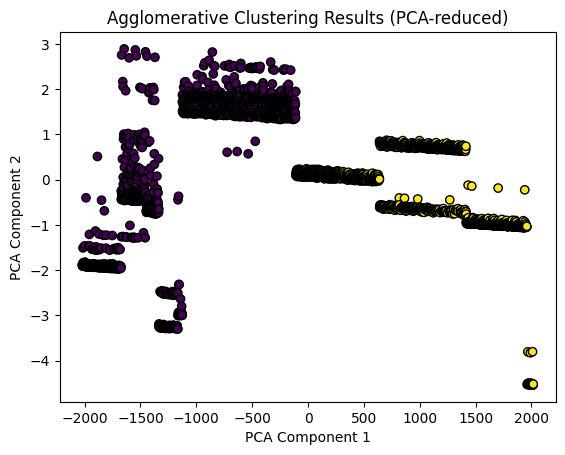

In [144]:
#Two clusters given the vertical line dendogram rule
pca = PCA(n_components=2)
df_2d = pca.fit_transform(df)

cluster = AgglomerativeClustering(n_clusters=2, linkage='ward', metric='euclidean')
labels = cluster.fit_predict(df)
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title('Agglomerative Clustering Results (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [145]:
#Automating cluster search under a specified range
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']

best_score = -1
best_params = {}

for linkage in linkage_methods:
    # Ward linkage only supports euclidean metric
    metrics = ['euclidean']

    for metric in metrics:
        for n_clusters in range_n_clusters:
            try:
                clusterer = AgglomerativeClustering(
                    n_clusters=n_clusters,
                    linkage=linkage,
                    metric=metric
                )
                labels = clusterer.fit_predict(df)
                score = silhouette_score(df, labels, metric=metric)
                print(f"Linkage: {linkage}, Metric: {metric}, Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

                if score > best_score:
                    best_score = score
                    best_params = {
                        'linkage': linkage,
                        'metric': metric,
                        'n_clusters': n_clusters,
                        'score': score
                    }
            except Exception as e:
                # Some metric-linkage combos may not be valid; skip those
                print(f"Skipping linkage={linkage}, metric={metric}, n_clusters={n_clusters} due to error: {e}")

print("\nBest parameters found:")
print(best_params)


Linkage: ward, Metric: euclidean, Clusters: 2, Silhouette Score: 0.6412
Linkage: ward, Metric: euclidean, Clusters: 3, Silhouette Score: 0.5918
Linkage: ward, Metric: euclidean, Clusters: 4, Silhouette Score: 0.5463
Linkage: ward, Metric: euclidean, Clusters: 5, Silhouette Score: 0.5342
Linkage: ward, Metric: euclidean, Clusters: 6, Silhouette Score: 0.5303
Linkage: ward, Metric: euclidean, Clusters: 7, Silhouette Score: 0.5263
Linkage: ward, Metric: euclidean, Clusters: 8, Silhouette Score: 0.5177
Linkage: ward, Metric: euclidean, Clusters: 9, Silhouette Score: 0.5181
Linkage: ward, Metric: euclidean, Clusters: 10, Silhouette Score: 0.5161
Linkage: complete, Metric: euclidean, Clusters: 2, Silhouette Score: 0.6390
Linkage: complete, Metric: euclidean, Clusters: 3, Silhouette Score: 0.5602
Linkage: complete, Metric: euclidean, Clusters: 4, Silhouette Score: 0.5398
Linkage: complete, Metric: euclidean, Clusters: 5, Silhouette Score: 0.5370
Linkage: complete, Metric: euclidean, Clusters:

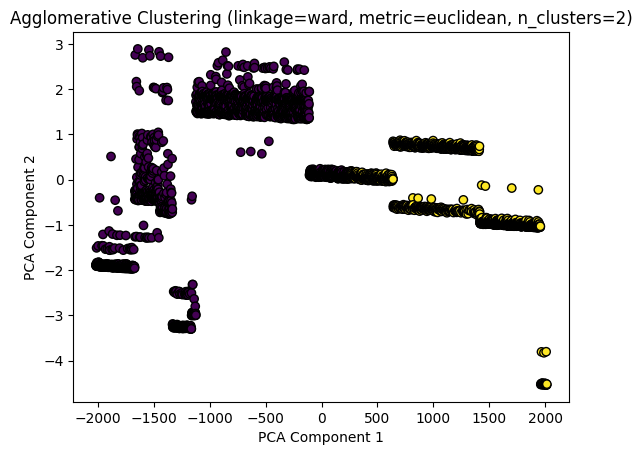

In [146]:
# Refit the best model
best_cluster = AgglomerativeClustering(
    n_clusters=best_params['n_clusters'],
    linkage=best_params['linkage'],
    metric=best_params['metric']
)
labels = best_cluster.fit_predict(df)

# Reduce data to 2D with PCA for visualization
pca = PCA(n_components=2)
df_2d = pca.fit_transform(df)

# Plot clusters with colors
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=labels, cmap='viridis', edgecolor='k')
plt.title(f"Agglomerative Clustering (linkage={best_params['linkage']}, "
          f"metric={best_params['metric']}, n_clusters={best_params['n_clusters']})")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
